# Light Curve Classifier
***

## Learning Goals
By the end of this tutorial, you will be able to:
- do some basic data cleaning and filtering to prepare the data for the ML algorithms
- work with Pandas data frames as a way of storing time domain datasets
- use sktime algorithms to train a classifier and predict values on a test dataset

## Introduction
This notebook takes output of a previous demo notebook which generates light curves from archival data, does data prep, and runs the light curves through multiple [`sktime`](https://www.sktime.net/en/stable/) classifiers.  The goal of the classifiers is to be able to differentiate changing look active galactic nucleii (CLAGN) from an SDSS quasar sample based on multiband light curves.  CLAGN are quite interested objects in that they appear to change state, but only a few hundred are currently known, and finding them is quite expensive requiring spectroscopic follow up.  Being able to identify CLAGN in existing large samples would allow us to identify a statisitcal sample from which we could better understand the physics of what is occuring in these systems.

The challenges of this time-domain dataset are:
1. Multi-variate = There are multiple bands of observations per target (13+)
2. Unequal length = Each band has a light curve with different sampling than other bands
3. Missing data = Not each object has all observations in all bands

We choose to use a Pandas multiindex dataframe to store and work with the data because it fulfills these requirements:
1. It can handle the above challenges of a dataset = multi-variate, unqueal length with missing data.
2. Multiple targets (multiple rows)
3. Pandas has some built in understanding of time units
4. Can be scaled up to big data numbers of rows (altough we don't push to out of memory structures in this use case)
5. Pandas is user friendly


## Input
Light curve parquet file of multiband light curves from the mulitband_lc.ipynb demo notebook.  The format of the light curves is a Pandas multiindex data frame

A useful reference for what sktime expects as input to its ML algorithms: https://github.com/sktime/sktime/blob/main/examples/AA_datatypes_and_datasets.ipynb

## Output
Trained classifiers as well as estimates of their accuracy and plots of confusion matrices

## Imports
- `pandas` to work with light curve data structure
- `numpy` for numerical calculations
- `matplotlib` for plotting
- `sys` for paths
- `astropy` to work with coordinates/units and data structures
- `tqdm` for showing progress meter
- `sktime` ML algorithms specifically for time-domain data
- `sklearn` general use ML algorthims with easy to use interface

## Authors

## Acknowledgements

In [1]:
#ensure all dependencies are installed
!pip install -r requirements-lc_classifier.txt


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from google_drive_downloader import GoogleDriveDownloader as gdd
from scipy.stats import sigmaclip

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsRegressor

from sktime.classification.deep_learning import CNNClassifier
from sktime.classification.dictionary_based import IndividualTDE
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.dummy import DummyClassifier
from sktime.classification.ensemble import WeightedEnsembleClassifier
from sktime.classification.feature_based import Catch22Classifier, RandomIntervalClassifier
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.classification.kernel_based import Arsenal, RocketClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.registry import all_estimators, all_tags
from tqdm import tqdm

# local code imports
sys.path.append('code_src/')
from fluxconversions import mjd_to_jd

## 1. Read in a dataset of archival light curves

In [3]:
#access structure of light curves made in the light curve notebook
# has CLAGN & SDSS small sample, all bands
#https://drive.google.com/file/d/13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz/view?usp=share_link

gdd.download_file_from_google_drive(file_id='13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz',
                                    dest_path='./data/df_lc_458sample.parquet',
                                    unzip=True)

df_lc = pd.read_parquet("./data/df_lc_458sample.parquet")
#get rid of indices set in the light curve code and reset them as needed before sktime algorithms
df_lc = df_lc.reset_index()  
df_lc.dtypes


objectid      int64
label        object
band         object
time        float64
flux        float64
err         float64
dtype: object

## 2. Data Prep
This dataset needs significant work before it can be fed into a ML algorithm

In [4]:
#what does the dataset look like anyway?
df_lc

,objectid,label,band,time,flux,err
0,112,Lopez-Navas 22,FERMIGTRIG,56371.813768,0.100000,0.100000
1,218,SDSS,FERMIGTRIG,59568.171278,0.100000,0.100000
2,395,SDSS,FERMIGTRIG,54699.331556,0.100000,0.100000
3,414,SDSS,FERMIGTRIG,56369.455916,0.100000,0.100000
4,434,SDSS,FERMIGTRIG,58941.402522,0.100000,0.100000
...,...,...,...,...,...,...
426627,183,SDSS,w2,55230.410156,6.717855,0.019561
426628,183,SDSS,w2,57054.886719,6.715584,0.023281
426629,183,SDSS,w2,57247.308594,7.572342,0.024136
426630,183,SDSS,w2,57977.214844,7.876407,0.023734


### 2.1 Remove bands with not enough data

In [5]:
##what are the unique set of bands included in our light curves
df_lc.band.unique()

array(['FERMIGTRIG', 'IceCube', 'zg', 'zr', 'zi', 'panstarrs i',
       'panstarrs y', 'panstarrs z', 'panstarrs g', 'panstarrs r',
       'Gaia g', 'Gaia bp', 'Gaia rp', 'K2', 'TESS', 'w1', 'w2'],
      dtype=object)

In [6]:
## get rid of some of the bands that don't have enough data for all the sources
bands_to_drop = ["IceCube", "TESS", "FERMIGTRIG", "K2"]
df_lc = df_lc[~df_lc["band"].isin(bands_to_drop)]


### 2.2 Combine Labels for a Simpler Classification
All CLAGN start in the dataset as having labels based on their discovery paper.  Because we want one sample with all known CLAGN, change those discoery names to be simply "CLAGN" for all CLAGN, regardless of origin

In [7]:

df_lc['label'] = df_lc.label.str.replace('MacLeod 16', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('LaMassa 15', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Yang 18', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lyu 21', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Hon 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Sheng 20', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('MacLeod 19', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Green 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lopez-Navas 22', 'CLAGN')



/tmp/ipykernel_4700/2260488855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('MacLeod 16', 'CLAGN')
/tmp/ipykernel_4700/2260488855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('LaMassa 15', 'CLAGN')
/tmp/ipykernel_4700/2260488855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

### 2.3 Remove some rows based on filtering out bad data

In [8]:
#find and drop bad rows

#one panstarrs z has a crazy err value of -999000, definitely don't want to include that one
querystring = 'err < -100'
df_lc = df_lc.drop(df_lc.query(querystring).index)

#drop rows which have Nans
df_lc.dropna(inplace = True, axis = 0)

#drop ~8 rows with zero flux
#We are going to define zero flux later to be missing data, but not sure what these are
querystring = 'flux < 0.000001'
df_lc = df_lc.drop(df_lc.query(querystring).index)



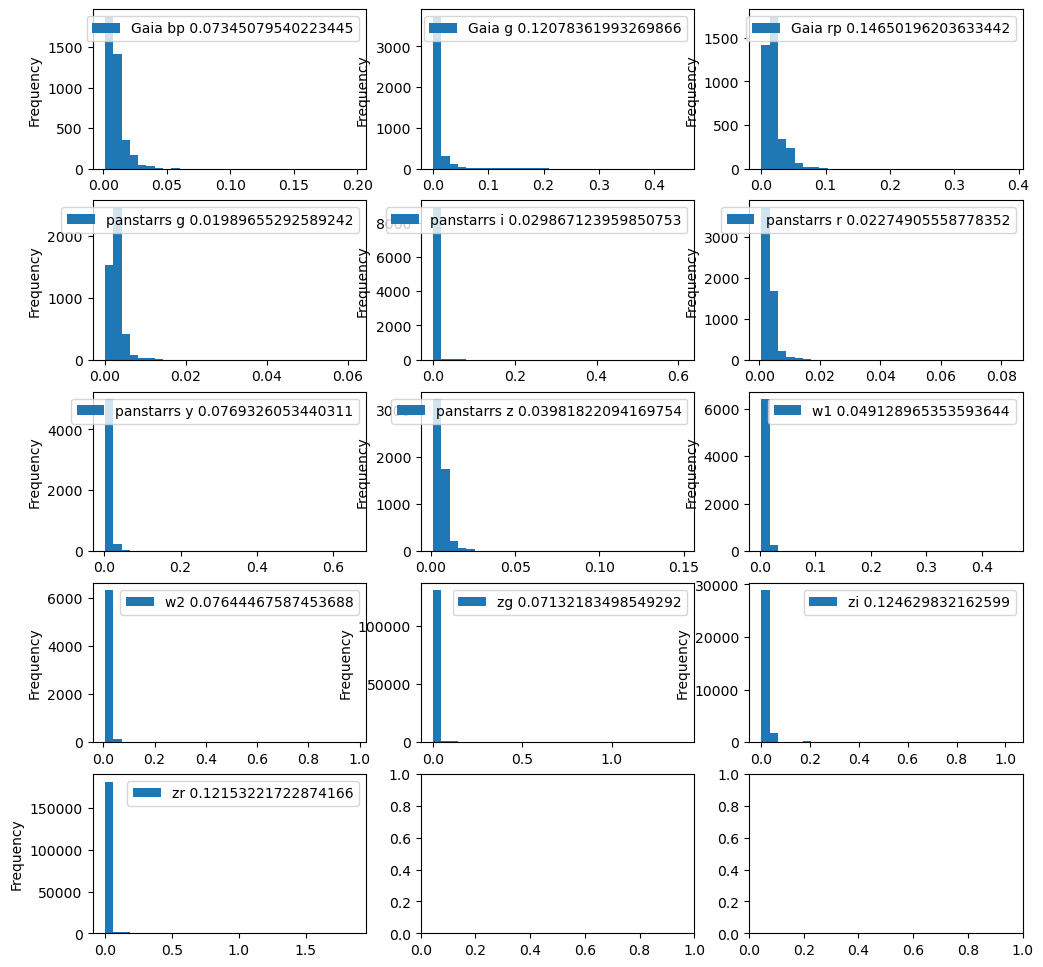

In [9]:
#consider Removing all rows with Signal to noise ratios outside of a normal distribution
#plot histograms to see what these distributions look like

#keep track of how many rows this removes
start_len = len(df_lc)

#first need a Signal to noise ratio column
df_lc["SNR"] = df_lc.flux / df_lc.err

#setup to collect the outlier thresholds
threesigmaonmean= {}

#create the figure and axes
fig, axs = plt.subplots(5, 3, figsize = (12, 12))
# unpack all the axes subplots
axe = axs.ravel()

#for each band
for count, (bandname, singleband) in enumerate(df_lc.groupby("band")):
    clippedarr, lower, upper = sigmaclip(singleband.err, low = 10.0, high = 10.0)
    threesigmaonmean[bandname] = upper
    #plot distributions and print stddev
    singleband.err.plot(kind = 'hist', bins = 30, subplots =True, ax = axe[count],label = bandname+' '+str(upper), legend=True)



In [10]:
#make it so
for bandname, cut in threesigmaonmean.items():
    querystring = f'band == {bandname!r} & err > {cut}'
    print(querystring)
    df_lc = df_lc.drop(df_lc.query(querystring).index)

band == 'Gaia bp' & err > 0.07345079540223445
band == 'Gaia g' & err > 0.12078361993269866
band == 'Gaia rp' & err > 0.14650196203633442
band == 'panstarrs g' & err > 0.01989655292589242
band == 'panstarrs i' & err > 0.029867123959850753
band == 'panstarrs r' & err > 0.02274905558778352
band == 'panstarrs y' & err > 0.0769326053440311
band == 'panstarrs z' & err > 0.03981822094169754
band == 'w1' & err > 0.049128965353593644
band == 'w2' & err > 0.07644467587453688
band == 'zg' & err > 0.07132183498549292
band == 'zi' & err > 0.124629832162599
band == 'zr' & err > 0.12153221722874166


In [11]:
end_len = len(df_lc)
fraction = (start_len - end_len) / start_len
print(f"This sigma clipping removed {fraction}% of the rows in df_lc")

This sigma clipping removed 0.01239000995250949% of the rows in df_lc


### 2.4 Incomplete Data

Some objects have only a few datapoints.  Three data points is not arge enough for KNN interpolation, so we will consider any array with fewer than 4 photometry points to be incomplete data.

We choose to remove those light curves with 3 or fewer data points.


In [12]:
#Define what the threshold is for too few datapoints.
thresh_too_few = 3

#how many groups do we have before we start
print(df_lc.groupby(["band", "objectid"]).ngroups, "n groups before")

#use pandas .filter to remove small groups
df_lc = df_lc.groupby(["band", "objectid"]).filter(lambda x: len(x) > thresh_too_few)

#how many groups do we have after culling?
print(df_lc.groupby(["band", "objectid"]).ngroups, "n groups after")

#currently this seems like a lot of groups because we still have the gaia single photometry points for many objects



5228 n groups before
4236 n groups after


### 2.5 Missing Data
Some objects do not have light curves in all bands.  Some ML algorithms can handle mising data, but not all, so it would be useful to handle this missing data up front.

We will add light curves with zero flux and err values for the missing data.  SKtime does not like NaNs, so we chose zeros.


In [13]:

#Later in the code we will need to noramalize fluxes by one of the bands
#This cell aims to figure out which band has the most data before we go and fill in missing data

#how many objects are there total?
total_objectids = df_lc.groupby( "objectid").ngroups

#how many objects have at least 1 flux in each of the band?
full_bandname = df_lc.band.unique()
for band in full_bandname:
    df_lc_band = df_lc[df_lc.band == band]
    total_band = df_lc_band.groupby("objectid").ngroups
    print(total_band/total_objectids, " have ", band, " fluxes" )



0.8663697104677061  have  zg  fluxes
0.8953229398663697  have  zr  fluxes
0.7060133630289532  have  zi  fluxes
0.9220489977728286  have  panstarrs i  fluxes
0.8663697104677061  have  panstarrs y  fluxes
0.9020044543429844  have  panstarrs z  fluxes
0.8752783964365256  have  panstarrs g  fluxes
0.9042316258351893  have  panstarrs r  fluxes
0.2026726057906459  have  Gaia g  fluxes
0.2026726057906459  have  Gaia bp  fluxes
0.2026726057906459  have  Gaia rp  fluxes
0.9599109131403119  have  w1  fluxes
0.9287305122494433  have  w2  fluxes


In [14]:
#this argues for normalizing by w1 fluxes (later)
#We will therefore need to get rid of the 4% of light curves which do not have W1 data
#as there will be nothing to normalize those light curves with and we don't want to 
#have un-normalized data or data that has been normalized by a different band.  

#keep track of how many get dropped
dropcount = 0

#for each object
for oid , singleoid in df_lc.groupby("objectid"):
    #what bands does that object have
    bandname = singleoid.band.unique().tolist()
    
    #if it doesn't have W1:
    if 'w1' not in bandname:
        #delete this oid from the dataframe of light curves
        indexoid = df_lc[ (df_lc['objectid'] == oid)].index
        df_lc.drop(indexoid , inplace=True)
        
        #keep track of how many are being deleted
        dropcount = dropcount + 1
        
        
print( dropcount, "objects do not have W1 fluxes and were removed")

18 objects do not have W1 fluxes and were removed


In [15]:
def make_zero_lc(oid, band, label):
    #randomly choose some times during the WISE survey
    #these will all get fleshed out in the section on making uniform length time arrays
    #so the specifics are not important now
    timelist = [55230,57054, 57247, 57977, 58707]  
    
    #make a dictionary to hold the light curve
    zerosingle = {"objectid": oid, "label": label, "band": band, "time": timelist, 
                  "flux": np.zeros(len(timelist)), "err":np.zeros(len(timelist))}
    
    return zerosingle


In [16]:
#for the case where there is no photometry in a band:
#make light curves with flux, err set to zeros

#what is the full set of unique band names?
full_bandname = df_lc.band.unique()

#setup a list to store empty light curves
zerosingle_list = [] 

#for each object in each band
for oid , singleoid in df_lc.groupby("objectid"):
                                  
    #this is the list of bandnames for that object                                
    oid_bandname = singleoid.band.unique()
    
    #figure out which bands are missing
    missing = list(set(full_bandname).difference(oid_bandname))
    
    #if it is not the complete list, ie some bandnames are missing:                            
    if len(missing) > 0:
    
        #make new dataframe for this object with zero flux and err values
        for m in range(len(missing)):
            label = str(singleoid.label.unique().squeeze())
            zerosingle = make_zero_lc(oid, missing[m], label)
            #keep track of these empty light curces in a list
            zerosingle_list.append(zerosingle)

            
#turn the empty light curves into a dataframe
df_empty = pd.DataFrame(zerosingle_list)
# df_empty has one row per dict. time,flux, and err columns store arrays.
# "explode" the dataframe to get one row per light curve point. time, flux, and err columns will now store floats.
df_empty = df_empty.explode(["time", "flux","err"], ignore_index=True)

#now put the empty light curves back together with the main light curve dataframe
df_lc = pd.concat([df_lc, df_empty])

### 2.5  Make all objects and bands have identical time arrays (uniform length and spacing)

It is very hard to find time-domain ML algorithms which can handle non uniform length datasets. Therefore we make them uniform using Pandas [reindex](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html) which fills in the uniform length arrays with values according to the method chosen by the user.  We implement a nearest neighbor to fill the arrays.  

try a sklearn regressor to fit the shape of the light curve and do interpolation

Potential other options for uniformizing the time series dataset:
- pandas.dataframe.interpolate with many methods

In [17]:
df_lc

,objectid,label,band,time,flux,err,SNR
1379,92,CLAGN,zg,58202.309236,0.736736,0.010347,71.205117
1380,92,CLAGN,zg,58202.31456,0.730595,0.01029,70.997201
1381,92,CLAGN,zg,58205.302651,0.658396,0.009634,68.338054
1382,92,CLAGN,zg,58205.320949,0.681111,0.00984,69.219502
1383,92,CLAGN,zg,58208.357257,0.589205,0.009014,65.364659
...,...,...,...,...,...,...,...
7280,457,SDSS,Gaia rp,55230,0.0,0.0,NaN
7281,457,SDSS,Gaia rp,57054,0.0,0.0,NaN
7282,457,SDSS,Gaia rp,57247,0.0,0.0,NaN
7283,457,SDSS,Gaia rp,57977,0.0,0.0,NaN


CPU times: user 1min 42s, sys: 759 ms, total: 1min 43s
Wall time: 12.1 s


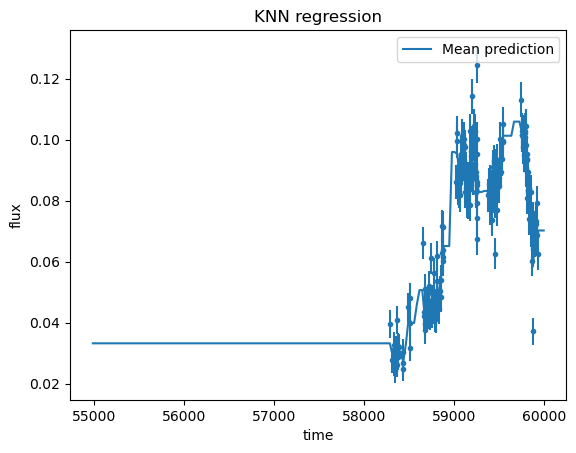

In [18]:
%%time

#change this to change the frequency of the time array
final_freq_int = 30  #this is the timescale of interpolation in units of days

#make a time array with the minimum and maximum of all light curves in the sample
x_interpol = np.arange(df_lc.time.min(), df_lc.time.max(), final_freq_int)
x_interpol = x_interpol.reshape(-1, 1) # needed for sklearn
lc_interpol = []  # list to store interpolated light curves

#look at each object in each band
for (band,oid) , singleband_oid in df_lc.groupby(["band", "objectid"]):
    #singleband_oid is now a dataframe with just one object and one band
    X = np.array(singleband_oid["time"]).reshape(-1, 1)
    y = np.array(singleband_oid["flux"])
    dy = np.array(singleband_oid["err"])
    
    #kernel = 1.0 * RBF(length_scale=30)
    #gp = GaussianProcessRegressor(kernel=kernel, alpha=dy**2, normalize_y = False)
    #gp.fit(X, y)
    #mean_prediction,std_prediction = gp.predict(x_interpol, return_std=True)

    #try KNN
    KNN = KNeighborsRegressor(n_neighbors = 3)
    KNN.fit(X, y)
    mean_prediction = KNN.predict(x_interpol)
        
    #KNN doesnt output an uncertainty array, so make our own:
    #an array of the same length as mean_prediction
    #having values equal to the mean of the original uncertainty array
    err = np.full_like(mean_prediction, singleband_oid.err.mean())  
        
    #get these values into the dataframe
    # append the results as a dict. the list will be converted to a dataframe later.
    lc_interpol.append(
        {"objectid": oid, "label": str(singleband_oid.label.unique().squeeze()), "band": band, "time": x_interpol.reshape(-1), 
         "flux": mean_prediction, "err": err}
    )
    
        
    #se what this looks like on just a single light curve for now
    if (band == 'zr') and (oid == 9) :  
        #see if this looks reasonable
        plt.errorbar(X,y,dy,linestyle="None",color="tab:blue",marker=".")
        plt.plot(x_interpol, mean_prediction, label="Mean prediction")
        #plt.fill_between(
        #    x_interpol.ravel(),
        #    mean_prediction - 1.96 * std_prediction,
        #    mean_prediction + 1.96 * std_prediction,
        #    color="tab:orange",
        #    alpha=0.5,
        #    label=r"95% confidence interval",
        #)
        plt.legend()
        plt.xlabel("time")
        plt.ylabel("flux")
        _ = plt.title("KNN regression")
        
        
# create a dataframe of the interpolated light curves
df_lc = pd.DataFrame(lc_interpol)
# df_lc_interpol has one row per dict in lc_interpol. time and flux columns store arrays.
# "explode" the dataframe to get one row per light curve point. time and flux columns will now store floats.
df_lc = df_lc.explode(["time", "flux","err"], ignore_index=True)

### 2.6  Restructure dataframe in format expected by sktime
- Make columns have band names in them and then remove band from the index
- pivot the dataframe so that SKTIME understands its format

In [19]:
df_lc = df_lc.set_index(["objectid", "label", "band", "time"])

In [20]:
df_lc = df_lc.reset_index(level="band").pivot(columns="band")
df_lc.columns = ["_".join(col) for col in df_lc.columns.values]

#many of these flux columns now have a space in them, fix that


In [21]:
#look at a single object to see what this array looks like
pd.set_option('display.max_rows', None)
display(df_lc.loc[4,:,:,:])
pd.reset_option('all')

flux_Gaia bp flux_Gaia g flux_Gaia rp flux_panstarrs g  \
label time                                                                  
CLAGN 54985.275796     0.075968    0.058815     0.173102         0.032355   
      55015.275796     0.075968    0.058815     0.173102         0.032355   
      55045.275796     0.075968    0.058815     0.173102         0.032355   
      55075.275796     0.075968    0.058815     0.173102         0.032355   
      55105.275796     0.075968    0.058815     0.173102         0.032355   
      55135.275796     0.075968    0.058815     0.173102         0.032355   
      55165.275796     0.075968    0.058815     0.173102         0.032355   
      55195.275796     0.075968    0.058815     0.173102         0.032355   
      55225.275796     0.075968    0.058815     0.173102         0.032355   
      55255.275796     0.075968    0.058815     0.173102         0.032355   
      55285.275796     0.075968    0.058815     0.173102         0.032355   
      55315.275796     0.075968    0.058815     0.173102         0.032355   
      55345.275796     0.075968    0.058815     0.173102         0.032355   
      55375.275796     0.075968    0.058815     0.173102         0.032355   
      55405.275796     0.075968    0.058815     0.173102         0.032355   
      55435.275796     0.075968    0.058815     0.173102         0.032355   
      55465.275796     0.075968    0.058815     0.173102         0.039053   
      55495.275796     0.075968    0.058815     0.173102         0.039053   
      55525.275796     0.075968    0.058815     0.173102         0.039053   
      55555.275796     0.075968    0.058815     0.173102         0.039053   
      55585.275796     0.075968    0.058815     0.173102         0.039053   
      55615.275796     0.075968    0.058815     0.173102         0.039053   
      55645.275796     0.075968    0.058815     0.173102         0.039053   
      55675.275796     0.075968    0.058815     0.173102         0.039053   
      55705.275796     0.075968    0.058815     0.173102         0.039053   
      55735.275796     0.075968    0.058815     0.173102         0.039053   
      55765.275796     0.075968    0.058815     0.173102         0.039053   
      55795.275796     0.075968    0.058815     0.173102         0.039053   
      55825.275796     0.075968    0.058815     0.173102         0.039301   
      55855.275796     0.075968    0.058815     0.173102         0.039301   
      55885.275796     0.075968    0.058815     0.173102         0.039301   
      55915.275796     0.075968    0.058815     0.173102         0.039301   
      55945.275796     0.075968    0.058815     0.173102         0.039301   
      55975.275796     0.075968    0.058815     0.173102         0.039301   
      56005.275796     0.075968    0.058815     0.173102         0.027282   
      56035.275796     0.075968    0.058815     0.173102         0.027282   
      56065.275796     0.075968    0.058815     0.173102         0.027282   
      56095.275796     0.075968    0.058815     0.173102         0.027282   
      56125.275796     0.075968    0.058815     0.173102         0.027282   
      56155.275796     0.075968    0.058815     0.173102         0.027282   
      56185.275796     0.075968    0.058815     0.173102         0.027282   
      56215.275796     0.075968    0.058815     0.173102         0.027282   
      56245.275796     0.075968    0.058815     0.173102         0.027282   
      56275.275796     0.075968    0.058815     0.173102         0.027282   
      56305.275796     0.075968    0.058815     0.173102         0.027282   
      56335.275796     0.075968    0.058815     0.173102         0.027282   
      56365.275796     0.075968    0.058815     0.173102         0.028789   
      56395.275796     0.075968    0.058815     0.173102         0.028789   
      56425.275796     0.075968    0.058815     0.173102         0.028789   
      56455.275796     0.075968    0.058815     0.173102         0.028789   
      56485.275

/tmp/ipykernel_4700/3294020153.py:4: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
/tmp/ipykernel_4700/3294020153.py:4: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
/tmp/ipykernel_4700/3294020153.py:4: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option('all')


### 2.7 Normalize 
- this is normalizing across all bands
- think this is the right place to do this, rather than before we reindex over time 
    so that the final light curves are normalized since that is the chunk of information 
    which goes into the ML algorithms.
- chose max and not median or mean because there are some objects where the median flux = 0.0
    - if we did this before the reindexing, the median might be a non-zero value
- normalizing is required so that the CLAGN and it's comparison SDSS sample don't have different flux levels.


Idea here is that we normalize across each object.  So the algorithms will know for example that within one object W1 will be brighter than ZTF bands but from one object to the next, it will not know that one is brighter than the other.

In [22]:
# make a new column with max_r_flux for each objectid
df_lc['max_zr'] = df_lc.groupby('objectid', sort=False)["flux_zr"].transform('max')


In [23]:

#figure out which columns in the dataframe are flux columns
flux_cols = [col for col in df_lc.columns if 'flux' in col]

# make new normalized flux columns for all fluxes
df_lc[flux_cols] = df_lc[flux_cols].div(df_lc['max_zr'], axis=0)

ZeroDivisionError: float division by zero

### 2.8 Save this dataframe

In [ ]:
#save this dataframe to use for the ML below so we don't have to make it every time
parquet_savename = 'output/df_lc_ML.parquet'
df_lc.to_parquet(parquet_savename)
#print("file saved!")

In [ ]:
# could load a previously saved file in order to plot
#parquet_loadname = 'output/df_ML_091523.parquet'
#pivoted_df_reindex = MultiIndexDFObject()
#pivoted_df_reindex.data = pd.read_parquet(parquet_loadname)
#print("file loaded!")

## 3. Prep for ML algorithms in sktime



### 3.0 Consider data augmentation

1. https://arxiv.org/pdf/1811.08295.pdf which has the following github

    - https://github.com/gioramponi/GAN_Time_Series/tree/master
    - not easily usable
2. https://arxiv.org/pdf/2205.06758.pdf

3. ChatGPT - give multiindex df function and it will give a starting point for augmenting


Worried that augmenting noisy data just makes more noise


### 3.1 Train test split 
- Because thre are uneven numbers of each type (many more SDSS than CLAGN), we want to make sure to stratify evenly by type
- Random split


In [ ]:
#y is defined to be the labels
y = df_lc.droplevel('datetime').index.unique().get_level_values('label').to_series()

#want a stratified split based on label
train_ix, test_ix = train_test_split(df_lc.index.levels[0], stratify = y, shuffle = True, random_state = 43, test_size = 0.25)

train_df = df_lc.loc[train_ix]  
test_df = df_lc.loc[test_ix]   


In [ ]:
#what does it look like?
train_df

In [ ]:
#plot to show how many of each type of object in the test dataset

plt.figure(figsize=(6,4))
plt.title("Objects in the Test dataset")
h = plt.hist(test_df.droplevel('datetime').index.unique().get_level_values('label').to_series(),histtype='stepfilled',orientation='horizontal')


### 3.2 Convert df_lc into X and y

In [ ]:
#divide the dataframe into X and y for ML algorithms 

#X is the multiindex light curve without the labels
X_train  = train_df.droplevel('label')
X_test = test_df.droplevel('label')

#y are the labels, should be a series 
y_train = train_df.droplevel('datetime').index.unique().get_level_values('label').to_series()
y_test = test_df.droplevel('datetime').index.unique().get_level_values('label').to_series()



### 3.3 Check that the data types are ok for sktime

In [ ]:
#ask sktime if it likes the data type of X
from sktime.datatypes import check_is_mtype

check_is_mtype(X_train, mtype="pd-multiindex", scitype="Panel", return_metadata=True)
#check_is_mtype(X_test, mtype="pd-multiindex", scitype="Panel", return_metadata=True)

## 4. Run Machine Learning Algorithms on the light curves

We choose to use [sktime](https://www.sktime.net/en/stable/index.html) algorithms beacuse it is a library of many algorithms specifically tailored to time series datasets.  It is based on the sklearn library so syntax is familiar to many users.

Types of classifiers are listed [here](https://www.sktime.net/en/stable/api_reference/classification.html).

This notebook will invert the actual workflow and show you a single example of the algorithm which best fits the data and has the most accurate classifier. Then it will show how to write a for loop over a bunch of classifiers before narrowing it down to the most accurate.



In [ ]:
#what is the list of all possible classifiers that work with multivariate data
#all_tags(estimator_types = 'classifier')
classifiers = all_estimators("classifier", filter_tags={'capability:multivariate':True})
classifiers


### 4.1 The Most Accurate Classifier
See section 4.2 for how we landed with this algorithm


In [ ]:
#looks like RandomIntervalClassifier is performing the best for the CLAGN (not for the SDSS)

#setup the classifier
clf = RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43)

#fit the classifier on the training dataset
clf.fit(X_train, y_train)

#make predictions on the test dataset using the trained model 
y_pred = clf.predict(X_test)

print(f"Accuracy of Random Interval Classifier: {accuracy_score(y_test, y_pred)}\n", flush=True)

#plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
    
plt.show()

### 4.2 Loop over a bunch of classifiers

Our method is to do a cursory check of a bunch of classifiers and then later drill down deeper on anything with good initial results.  We choose to run a loop over ~10 classifiers that seem promising and check the accuracy scores for each one.  Any classifier with a promising accuracy score could then be followed up with detailed hyperparameter tuning, or potentially with considering other classifiers in that same type.

In [ ]:
#which classifiers are we interestd in
#roughly one from each type of classifier

names = ["Arsenal",                     #kernel based
        "RocektClassifier",             #kernel based
        "CanonicalIntervalForest",      #interval based
        "HIVECOTEV2",                   #hybrid
#        "CNNClassifier",               #Deep Learning  - **requires tensorflow which is giving import errors
#        "WeightedEnsembleClassifier",   #Ensemble - **maybe use in the future if we find good options
        "IndividualTDE",               #Dictionary-based
        "KNeighborsTimeSeriesClassifier", #Distance Based
        "RandomIntervalClassifier",     #Feature based
        "Catch22Classifier",            #Feature based
        "ShapeletTransformClassifier"   #Shapelet based
        "DummyClassifier"]             #Dummy - ignores input

#for those with an impossible time limit, how long to let them run for before cutting off
nmins = 10

#these could certainly be more tailored
classifier_call = [Arsenal(time_limit_in_minutes=nmins, n_jobs = -1), 
                  RocketClassifier(num_kernels=2000),
                  CanonicalIntervalForest(n_jobs = -1),
                  HIVECOTEV2(time_limit_in_minutes=nmins, n_jobs = -1),
#                  CNNClassifier(),
#                  WeightedEnsembleClassifier(),
                  IndividualTDE(n_jobs=-1),
                  KNeighborsTimeSeriesClassifier(n_jobs = -1),
                  RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43),
                  Catch22Classifier(outlier_norm = True, n_jobs = -1, random_state = 43),
                  ShapeletTransformClassifier(time_limit_in_minutes=nmins,n_jobs = -1),
                  DummyClassifier()]

#setup to store the accuracy scores
accscore_dict = {}

# iterate over classifiers
for name, clf in tqdm(zip(names, classifier_call)):
    #fit the classifier
    clf.fit(X_train, y_train)
    
    #make predictions on the test dataset
    y_pred = clf.predict(X_test)

    #calculate and track accuracy score
    accscore = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name} classifier: {accscore}\n", flush=True)
    accscore_dict[name] = accscore
    
    #plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()

#just for keeping track, I also tried 
#clf = SignatureClassifier(depth = 2, window_depth = 3, random_state = 43)
#this fails to complete, and is a known limitation of this algorithm.  

In [ ]:
#show the summary of the algorithms used and their accuracy score
accscore_dict

## 5.0 Conclusions:  
This classifier can be used to predict CLAGN.  The feature based algorithms do the best jobs of having little to no predicted CLAGN that are truly normal SDSS quasars.  We infer then that if the trained model predicts CLAGN, it is a very good target for follow-up spectroscopy to confirm CLAGN.  However this algorthim will not catch all CLAGN, and will incorrectly labels some CLAGN as being normal SDSS quasars.  THis algorithm can therefore not be used to find a complete sample of CLAGN, but can be used to increase the known sample.


### 5.1 Potential Areas of improvement
- Data is messy
    - ZTF calibration??
- Label inaccuracy is a concern
    - mostly SDSS, 
    - but CLAGN papers all have different selection criteria
- Not enough data on CLAGN
    - limited number of lightcurves
    - consider data augmentation